In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [4]:
# Loading the Data Set

movies = pd.read_csv('./ml-25m/movies.csv')
rating = pd.read_csv('./ml-25m/ratings.csv')

In [7]:
# the function to extract titles 
def extract_title(title):
    year = title[len(title)-5:len(title)-1]
   
   # some movies do not have the info about year in the column title. So, we should take care of the case as well.
   
    if year.isnumeric():
        title_no_year = title[:len(title)-7]
        return title_no_year
    else:
        return title
# the function to extract years
def extract_year(title):
    year = title[len(title)-5:len(title)-1]
   # some movies do not have the info about year in the column title. So, we should take care of the case as well.
    if year.isnumeric():
        return int(year)
    else:
        return np.nan

    # change the column name from title to title_year
movies.rename(columns={'title':'title_year'}, inplace=True) 
# remove leading and ending whitespaces in title_year
movies['title_year'] = movies['title_year'].apply(lambda x: x.strip()) 
# create the columns for title and year
movies['title'] = movies['title_year'].apply(extract_title) 
movies['year'] = movies['title_year'].apply(extract_year) 

In [9]:
r,c = movies[movies['genres']=='(no genres listed)'].shape
print('The number of movies which do not have info about genres:',r)

# remove the movies without genre information and reset the index
movies = movies[~(movies['genres']=='(no genres listed)')].reset_index(drop=True)

The number of movies which do not have info about genres: 5062


Text(0, 0.5, 'Counts')

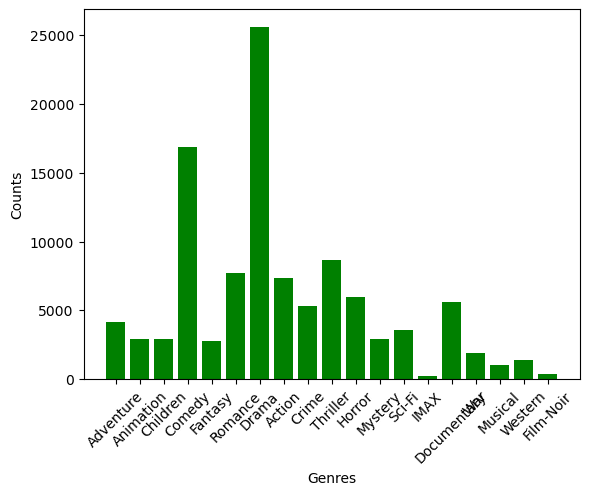

In [12]:
# remove '|' in the genres column
movies['genres'] = movies['genres'].str.replace('|',' ')
# count the number of occurences for each genre in the data set
counts = dict()
for i in movies.index:
    for g in movies.loc[i,'genres'].split(' '):
        if g not in counts:
            counts[g] = 1
        else:
            counts[g] = counts[g] + 1
# create a bar chart
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
# change 'Sci-Fi' to 'SciFi' and 'Film-Noir' to 'Noir'
movies['genres'] = movies['genres'].str.replace('Sci-Fi','SciFi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','Noir')
# create an object for TfidfVectorizer
tfidf_vector = TfidfVectorizer(stop_words='english')
# apply the object to the genres column
tfidf_matrix = tfidf_vector.fit_transform(movies['genres'])

In [14]:
tfidf_matrix.shape

(57361, 19)

In [15]:
print(list(enumerate(tfidf_vector.get_feature_names())))

[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'children'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'horror'), (10, 'imax'), (11, 'musical'), (12, 'mystery'), (13, 'noir'), (14, 'romance'), (15, 'scifi'), (16, 'thriller'), (17, 'war'), (18, 'western')]


In [17]:
from sklearn.metrics.pairwise import linear_kernel
# create the cosine similarity matrix
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix) 
print(sim_matrix)

[[1.         0.828194   0.16276817 ... 0.         0.21240484 0.31905143]
 [0.828194   1.         0.         ... 0.         0.         0.38523755]
 [0.16276817 0.         1.         ... 0.         0.46165262 0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.21240484 0.         0.46165262 ... 0.         1.         0.2244596 ]
 [0.31905143 0.38523755 0.         ... 0.         0.2244596  1.        ]]


In [21]:
from fuzzywuzzy import fuzz
# create a function to find the closest title
def matching_score(a,b):
    return fuzz.ratio(a,b)



In [22]:
# a function to convert index to title_year
def get_title_year_from_index(index):
    return movies[movies.index == index]['title_year'].values[0]
# a function to convert index to title
def get_title_from_index(index):
    return movies[movies.index == index]['title'].values[0]
# a function to convert title to index
def get_index_from_title(title):
    return movies[movies.title == title].index.values[0]
# a function to return the most similar title to the words a user type
def find_closest_title(title):
    leven_scores = list(enumerate(movies['title'].apply(matching_score, b=title)))
    sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
    closest_title = get_title_from_index(sorted_leven_scores[0][0])
    distance_score = sorted_leven_scores[0][1]
    return closest_title, distance_score


In [25]:
def contents_based_recommender(movie_user_likes, how_many):
    closest_title, distance_score = find_closest_title(movie_user_likes)
   # When a user does not make misspellings
    if distance_score == 100:
        movie_index = get_index_from_title(closest_title)
        movie_list = list(enumerate(sim_matrix[int(movie_index)]))
      # remove the typed movie itself
        similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True))) 
      
        print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
        for i,s in similar_movies[:how_many]:
            print(get_title_year_from_index(i))
    else:
        print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')
        movie_index = get_index_from_title(closest_title)
        movie_list = list(enumerate(sim_matrix[int(movie_index)]))
        similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True)))
        print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
        for i,s in similar_movies[:how_many]:
            print(get_title_year_from_index(i))

In [28]:
contents_based_recommender('Taken 2 (2012)', 20)

Did you mean Taken 2? 

Here's the list of movies similar to Taken 2.

Crossing Guard, The (1995)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Clear and Present Danger (1994)
Last Man Standing (1996)
Killer, The (Die xue shuang xiong) (1989)
Face/Off (1997)
Cop Land (1997)
Corruptor, The (1999)
Double Jeopardy (1999)
Fight Club (1999)
Patriot Games (1992)
Hard-Boiled (Lat sau san taam) (1992)
Boondock Saints, The (2000)
Magnum Force (1973)
Shaft (1971)
Blood In, Blood Out (1993)
Get Carter (1971)
Spy Game (2001)
Teheran 43: Spy Ring (a.k.a. Assassination Attempt) (Tegeran-43) (1980)
Dark Blue (2003)
